In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr

In [3]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [ ]:
df_departures['half_month'] = df_departures['date'].dt.to_period('M').astype(str) + df_departures['date'].dt.day.apply(lambda d: '-H1' if d <= 15 else '-H2')

grouped_dep = df_departures.groupby(['airportCode', 'half_month']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
})

grouped_dep.columns = ['_'.join(col) for col in grouped_dep.columns]

df_dep_by_airport = grouped_dep.reset_index().pivot(index='airportCode', columns='half_month')

df_dep_by_airport.columns = ['{}_{}'.format(metric, period) for metric, period in df_dep_by_airport.columns]

df_dep_by_airport = df_dep_by_airport.reset_index()


In [ ]:
df_arrivals['half_month'] = df_arrivals['date'].dt.to_period('M').astype(str) + df_arrivals['date'].dt.day.apply(lambda d: '-H1' if d <= 15 else '-H2')

grouped_arr = df_arrivals.groupby(['airportCode', 'half_month']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
})

grouped_arr.columns = ['_'.join(col) for col in grouped_arr.columns]

df_arr_by_airport = grouped_arr.reset_index().pivot(index='airportCode', columns='half_month')

df_arr_by_airport.columns = ['{}_{}'.format(metric, period) for metric, period in df_arr_by_airport.columns]

df_arr_by_airport = df_arr_by_airport.reset_index()


In [ ]:
df_all_by_airport = pd.merge(
    df_departures.add_suffix('_dep').reset_index(),
    df_arrivals.add_suffix('_arr').reset_index(),
    left_on='airportCode_dep',
    right_on='airportCode_arr',
    how='outer'
)

print(df_all_by_airport.head())

print(df_all_by_airport.shape)

In [ ]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

airportCode         0
week                0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode         0
week                0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode             0
week                    0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


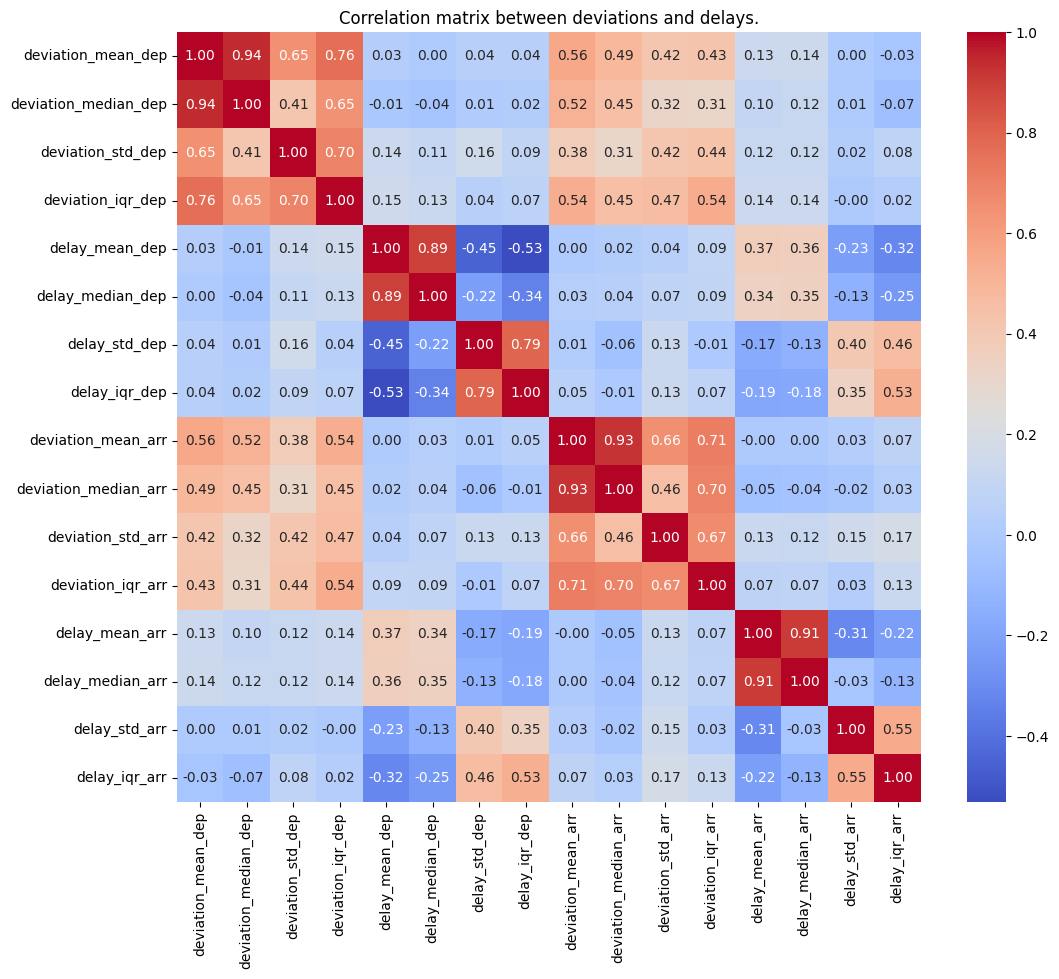

In [ ]:
df_numeric = df_all_by_airport.drop(columns=['airportCode', 'week'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [ ]:
X_dep = df_dep_by_airport.drop(columns=['airportCode', 'week']).dropna()

print(X_dep.head())
print()

scaler = StandardScaler()
X_scaled_dep = scaler.fit_transform(X_dep)

custom_tooltips_dep = np.array([
    f"{row['week']} – {row['airportCode']}" for _, row in df_dep_by_airport.iterrows()
])


print(X_scaled_dep)

   deviation_mean  deviation_median  deviation_std  deviation_iqr  delay_mean  \
0     1900.131556       1193.058225    2182.850892    1423.112477   -1.818310   
1     2461.975764       1570.759024    2519.339224    2525.597935   -1.823665   
2     2327.996683       1611.251859    2257.791342    2349.866870   -2.773789   
3     2394.508050       1545.287471    2531.621851    2238.085085   -1.495228   
4     2194.152453       1301.517463    2260.634047    2355.928244   -1.676171   

   delay_median  delay_std  delay_iqr  
0     -1.633333   7.746603  10.450000  
1     -1.291667   7.800265   8.804167  
2     -2.100000   8.040613   9.400000  
3     -1.350000   7.349823  10.066667  
4     -1.525000   7.291802   8.250000  

[[ 0.14186184 -0.2572973   0.9083209  ...  0.1499814  -0.12201043
   0.35935988]
 [ 0.82407518  0.215477    1.34947182 ...  0.21629824 -0.11367858
   0.07805842]
 [ 0.66139251  0.26616255  1.00657111 ...  0.05940232 -0.07636079
   0.17989667]
 ...
 [ 0.80023051  0.9405827

In [ ]:
X_arr = df_arr_by_airport.drop(columns=['airportCode', 'week']).dropna()

print(X_arr.head())
print()

scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(X_arr)

custom_tooltips_arr = np.array([
    f"{row['week']} – {row['airportCode']}" for _, row in df_arr_by_airport.iterrows()
])

print(X_scaled_arr)


   deviation_mean  deviation_median  deviation_std  deviation_iqr  delay_mean  \
0     2993.903521       3632.367611    2521.378984    4787.346775   -3.366414   
1     3235.367828       4084.204388    2522.180266    4952.727052   -4.501928   
2     3207.034938       3765.398291    2695.785145    5134.048443   -4.474066   
3     3157.905038       3948.505004    2596.698340    5086.576035   -3.672188   
4     3002.871355       3687.809836    2450.007385    4806.900975   -3.795076   

   delay_median  delay_std  delay_iqr  
0     -3.283333   6.326659  11.112500  
1     -4.658333   6.834916  10.429167  
2     -4.233333   7.927804  10.683333  
3     -3.733333   6.142696  10.162500  
4     -3.375000   6.622215   9.237500  

[[ 1.92164804  2.87307602  1.77004299 ... -0.25050754 -0.18283882
   0.9039728 ]
 [ 2.24868586  3.43339248  1.77117962 ... -0.45308584 -0.11811141
   0.75543315]
 [ 2.21031196  3.0380455   2.01743905 ... -0.39047073  0.02106987
   0.81068265]
 ...
 [ 0.07002837  0.0409900

In [ ]:
X_all = df_all_by_airport.drop(columns=['airportCode', 'week']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
    f"{row['week']} – {row['airportCode']}" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         1900.131556           1193.058225        2182.850892   
1         2461.975764           1570.759024        2519.339224   
2         2327.996683           1611.251859        2257.791342   
3         2394.508050           1545.287471        2531.621851   
4         2194.152453           1301.517463        2260.634047   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        1423.112477       -1.818310         -1.633333       7.746603   
1        2525.597935       -1.823665         -1.291667       7.800265   
2        2349.866870       -2.773789         -2.100000       8.040613   
3        2238.085085       -1.495228         -1.350000       7.349823   
4        2355.928244       -1.676171         -1.525000       7.291802   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0      10.450000         2993.903521           3632.367611        2521.378984   
1 

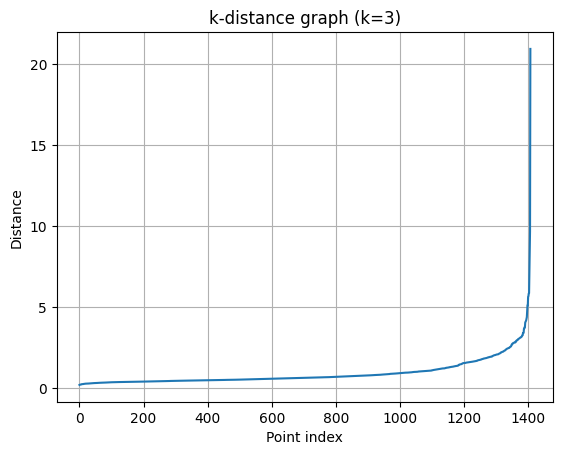

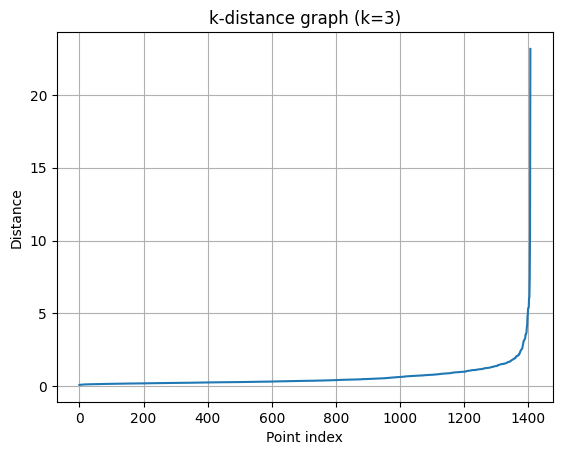

In [14]:

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_scaled_dep)
distances, indices = neighbors_fit.kneighbors(X_scaled_arr)
distances = np.sort(distances[:, 2])

plt.plot(distances)
plt.title("k-distance graph (k=3)")
plt.xlabel("Point index")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_scaled_arr)
distances, indices = neighbors_fit.kneighbors(X_scaled_arr)
distances = np.sort(distances[:, 2])

plt.plot(distances)
plt.title("k-distance graph (k=3)")
plt.xlabel("Point index")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

In [ ]:

mapper = km.KeplerMapper()

pca = PCA(n_components=3)
filter_values_dep = pca.fit_transform(X_scaled_dep)

node_color_function_dep = X_scaled_dep[:, X_dep.columns.get_loc("delay_mean")]

graph_dep = mapper.map(filter_values_dep,
                    X_scaled_dep,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=5, perc_overlap=0.2)
)

mapper.visualize(graph_dep, 
                 path_html="mapper_output_dep.html", 
                 custom_tooltips=custom_tooltips_dep, 
                 node_color_function=node_color_function_dep)

c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\kmapper\visuals.py:344: RuntimeWarning: invalid value encountered in scalar divide
  height = np.floor(((bar / max_bucket_value) * 100) + 0.5)
c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\kmapper\visuals.py:345: RuntimeWarning: invalid value encountered in scalar divide
  perc = round((bar / sum_bucket_value) * 100.0, 1)


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Kepler Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weigh

In [ ]:
pca = PCA(n_components=3)
filter_values_arr = pca.fit_transform(X_scaled_arr)

node_color_function_arr = X_scaled_arr[:, X_arr.columns.get_loc("delay_mean")]


graph_arr = mapper.map(filter_values_arr, 
                    X_scaled_arr,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=5, perc_overlap=0.2)
)

mapper.visualize(graph_arr, 
                 path_html="mapper_output_arr.html", 
                 custom_tooltips=custom_tooltips_arr, 
                 node_color_function=node_color_function_arr)

c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\kmapper\visuals.py:344: RuntimeWarning: invalid value encountered in scalar divide
  height = np.floor(((bar / max_bucket_value) * 100) + 0.5)
c:\Users\Raúl\Documents\MASTER\TFM\env\lib\site-packages\kmapper\visuals.py:345: RuntimeWarning: invalid value encountered in scalar divide
  perc = round((bar / sum_bucket_value) * 100.0, 1)


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Kepler Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weigh

In [ ]:
pca = PCA(n_components=3)
filter_values_all = pca.fit_transform(X_scaled_all)

node_color_function_all = (
    0.5 * X_scaled_all[:, X_all.columns.get_loc("delay_mean_dep")] +
    0.5 * X_scaled_all[:, X_all.columns.get_loc("delay_mean_arr")]
)

graph_all = mapper.map(filter_values_all, 
                    X_scaled_all,
                    clusterer=DBSCAN(eps=2.5, min_samples=3),
                    cover=km.Cover(n_cubes=5, perc_overlap=0.2)
)

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 node_color_function=node_color_function_all)

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Kepler Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weigh